<a id="1"></a>
## 1-The Aim of Project
My aim in this project is to develop and compare models capable of identifying and classifying different types of fruits and vegetables from images. First, I will build and train a CNN model. Then,  I will apply transfer learning techniques to build new models. Finally, I will compare and analyze the results of these models.

<a id="2"></a>
## 2-Libraries 

In [79]:
import os
import cv2
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns
from PIL import Image 
from pathlib import Path
import visualkeras
import mlflow
import mlflow.keras
from tensorflow.keras.models import load_model

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers, layers, models
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau,ModelCheckpoint 
from keras.optimizers import Adam
from keras.regularizers import l2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

import warnings 

warnings.filterwarnings('ignore')

<a id="3"></a>
## 3-Import Data

In [ ]:
train_path = "dataset_full_en_aug/train"
test_path = "dataset_full_en_aug/test"
validation_path = "dataset_full_en_aug/validation"

<div class="alert alert-block alert-danger">  
<h4>Warning!</h4>
I will not use the images in the test and validation sections as they are taken from the train images.
</div>

In [45]:
num_classes = len(os.listdir(train_path))
num_classes

60

In [46]:
label_list = os.listdir(train_path)
label_list

['Agaricus lemaneiformis',
 'Amaranth',
 'asparagus',
 'Baby Corn',
 'Bamboo shoots',
 'Basil',
 'Beef Tomato',
 'Bell pepper',
 'Big Chinese Cabbage',
 'Big cucumber',
 'Bok Choy',
 'Broccoli',
 'brocoli',
 'cabbage',
 'carrot',
 'celery',
 'chili',
 'Chinese Cabbage',
 'Chinese chives',
 'Chrysanthemum',
 'coriander',
 'corn',
 'cowpea',
 'Cucumber',
 'eggplant',
 'French beans',
 'Garlic',
 'Garlic sprouts',
 'ginger',
 'Green bamboo shoots',
 'green onion',
 'Green pepper',
 'Kale',
 'Lettuce',
 'Loofah',
 'Lotus root',
 'Mainland girl',
 'Momordica charantia',
 'Mountain Su',
 'Okra',
 'onion',
 'pea',
 'potato',
 'pumpkin',
 'rape',
 'Red broccoli',
 'Romaine',
 'Shallots',
 'spinach',
 'Sweet Pea',
 'sweet potato',
 'Sweet potato leaves',
 'Taro',
 'Water Lily',
 'Water spinach',
 'WaWa dishes',
 'White radish',
 'Winter melon',
 'Yam',
 'zucchini']

## class_weight

In [47]:
import os

class_names = sorted(os.listdir(train_path))  # ['broccoli', 'carrot', 'tomato', ...]
class_to_index = {name: idx for idx, name in enumerate(class_names)}

image_labels = []
for class_name in class_names:
    class_dir = os.path.join(train_path, class_name)
    if os.path.isdir(class_dir):
        count = len([f for f in os.listdir(class_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
        image_labels.extend([class_to_index[class_name]] * count)


In [48]:
# from sklearn.utils.class_weight import compute_class_weight
# import numpy as np

# image_labels = np.array(image_labels)
# weights = compute_class_weight(class_weight='balanced', classes=np.unique(image_labels), y=image_labels)
# class_weight = dict(zip(np.unique(image_labels), weights))
# print(class_weight)


{np.int64(0): np.float64(1.0219666666666667), np.int64(1): np.float64(1.0219666666666667), np.int64(2): np.float64(0.9788952745849298), np.int64(3): np.float64(1.0219666666666667), np.int64(4): np.float64(1.0219666666666667), np.int64(5): np.float64(1.0219666666666667), np.int64(6): np.float64(1.0219666666666667), np.int64(7): np.float64(1.0219666666666667), np.int64(8): np.float64(1.0219666666666667), np.int64(9): np.float64(1.0219666666666667), np.int64(10): np.float64(0.9733015873015873), np.int64(11): np.float64(1.0219666666666667), np.int64(12): np.float64(1.0219666666666667), np.int64(13): np.float64(1.0219666666666667), np.int64(14): np.float64(1.0219666666666667), np.int64(15): np.float64(1.0219666666666667), np.int64(16): np.float64(0.9980143229166667), np.int64(17): np.float64(1.0219666666666667), np.int64(18): np.float64(1.0219666666666667), np.int64(19): np.float64(1.0219666666666667), np.int64(20): np.float64(1.0219666666666667), np.int64(21): np.float64(1.0219666666666667

In [49]:
def load_image(data_path, img_size=224):
    X=[]
    y=[]
    label_list = os.listdir(data_path)
    label_num = np.arange(0,len(label_list))
    labels = dict(zip(label_list, label_num))
    
    for label in labels:
        path = Path(data_path)/label
        for img_name in os.listdir(path):
            img_path = Path(path,img_name)
            img = cv2.imread(img_path)
            print(img_path)
            if img is None:
                print(f'Skip {img_path} could not read image')
                continue 
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (img_size, img_size))
            X.append(img)
            y.append(labels[label])
    return np.array(X), np.array(y)

<a id="3.1"></a>
### Load Train Data 

In [50]:


train_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'  # 或 'sparse' 視你 y_label 而定
)
# Get class names as a list
classes = list(train_generator.class_indices.keys())
print(class_names)


test_generator = train_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'  # 或 'sparse' 視你 y_label 而定
)

validation_generator = train_datagen.flow_from_directory(
    validation_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'  # 或 'sparse' 視你 y_label 而定
)


Found 30659 images belonging to 60 classes.
['Agaricus lemaneiformis', 'Amaranth', 'Baby Corn', 'Bamboo shoots', 'Basil', 'Beef Tomato', 'Bell pepper', 'Big Chinese Cabbage', 'Big cucumber', 'Bok Choy', 'Broccoli', 'Chinese Cabbage', 'Chinese chives', 'Chrysanthemum', 'Cucumber', 'French beans', 'Garlic', 'Garlic sprouts', 'Green bamboo shoots', 'Green pepper', 'Kale', 'Lettuce', 'Loofah', 'Lotus root', 'Mainland girl', 'Momordica charantia', 'Mountain Su', 'Okra', 'Red broccoli', 'Romaine', 'Shallots', 'Sweet Pea', 'Sweet potato leaves', 'Taro', 'WaWa dishes', 'Water Lily', 'Water spinach', 'White radish', 'Winter melon', 'Yam', 'asparagus', 'brocoli', 'cabbage', 'carrot', 'celery', 'chili', 'coriander', 'corn', 'cowpea', 'eggplant', 'ginger', 'green onion', 'onion', 'pea', 'potato', 'pumpkin', 'rape', 'spinach', 'sweet potato', 'zucchini']
Found 2213 images belonging to 60 classes.
Found 4286 images belonging to 60 classes.


In [8]:
# X_train, y_train = load_image(train_path)
# X_train = X_train.astype('float32')/255.0

veg_img_eng\Agaricus lemaneiformis\Agaricus lemaneiformis1.jpeg
veg_img_eng\Agaricus lemaneiformis\Agaricus lemaneiformis10.jpeg
veg_img_eng\Agaricus lemaneiformis\Agaricus lemaneiformis100.jpg
veg_img_eng\Agaricus lemaneiformis\Agaricus lemaneiformis101.jpg
veg_img_eng\Agaricus lemaneiformis\Agaricus lemaneiformis102.jpg
veg_img_eng\Agaricus lemaneiformis\Agaricus lemaneiformis103.jpg
veg_img_eng\Agaricus lemaneiformis\Agaricus lemaneiformis104.jpg
veg_img_eng\Agaricus lemaneiformis\Agaricus lemaneiformis105.jpg
veg_img_eng\Agaricus lemaneiformis\Agaricus lemaneiformis106.jpg
veg_img_eng\Agaricus lemaneiformis\Agaricus lemaneiformis107.jpg
veg_img_eng\Agaricus lemaneiformis\Agaricus lemaneiformis108.jpg
veg_img_eng\Agaricus lemaneiformis\Agaricus lemaneiformis109.jpg
veg_img_eng\Agaricus lemaneiformis\Agaricus lemaneiformis11.jpg
veg_img_eng\Agaricus lemaneiformis\Agaricus lemaneiformis110.jpg
veg_img_eng\Agaricus lemaneiformis\Agaricus lemaneiformis111.jpg
veg_img_eng\Agaricus lemane

MemoryError: Unable to allocate 12.1 GiB for an array with shape (21571, 224, 224, 3) and data type float32

<a id="3.2"></a>
### Loading with tf Dataframe

<div class="alert alert-block alert-info"> I will use the one above in the visualization phase, and this one in the model and data augmentation phases.
</div>

In [13]:
# num_classes = len(os.listdir(train_path))
# num_classes

# batch_size = 32
# img_size = (128, 128)

# # Eğitim setini yükleme
# train_ds = tf.keras.preprocessing.image_dataset_from_directory(
#     train_path,
#     image_size=img_size,
#     batch_size=batch_size,
# )
# classes = train_ds.class_names
# normalization_layer = tf.keras.layers.Rescaling(1./255)
# train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))

# train_ds = train_ds.shuffle(buffer_size=1000)

# train_size = int(0.8 * len(train_ds)) 
# test_size = len(train_ds) - train_size

# train_dataset = train_ds.take(train_size)
# test_dataset = train_ds.skip(train_size)

# print(classes)

Found 21571 files belonging to 60 classes.
['Agaricus lemaneiformis', 'Amaranth', 'Baby Corn', 'Bamboo shoots', 'Basil', 'Beef Tomato', 'Bell pepper', 'Big Chinese Cabbage', 'Big cucumber', 'Bok Choy', 'Broccoli', 'Chinese Cabbage', 'Chinese chives', 'Chrysanthemum', 'Cucumber', 'French beans', 'Garlic', 'Garlic sprouts', 'Green bamboo shoots', 'Green pepper', 'Kale', 'Lettuce', 'Loofah', 'Lotus root', 'Mainland girl', 'Momordica charantia', 'Mountain Su', 'Okra', 'Red broccoli', 'Romaine', 'Shallots', 'Sweet Pea', 'Sweet potato leaves', 'Taro', 'WaWa dishes', 'Water Lily', 'Water spinach', 'White radish', 'Winter melon', 'Yam', 'asparagus', 'brocoli', 'cabbage', 'carrot', 'celery', 'chili', 'coriander', 'corn', 'cowpea', 'eggplant', 'ginger', 'green onion', 'onion', 'pea', 'potato', 'pumpkin', 'rape', 'spinach', 'sweet potato', 'zucchini']


In [ ]:
# import csv

# # 儲存類別名稱到 classes.csv
# with open('classes.csv', 'w', newline='', encoding='utf-8') as f:
#     writer = csv.writer(f)
#     for cls in classes:
#         writer.writerow([cls])


NameError: name 'classes' is not defined

In [14]:
# batch_size = 32
# img_size = (128, 128)

# # 訓練集
# train_ds = tf.keras.preprocessing.image_dataset_from_directory(
#     train_path,
#     validation_split=0.2,
#     subset="training",
#     seed=123,
#     image_size=img_size,
#     batch_size=batch_size
# )

# # 驗證集 / 測試集（你可以當作 test_dataset 用）
# val_ds = tf.keras.preprocessing.image_dataset_from_directory(
#     train_path,
#     validation_split=0.2,
#     subset="validation",
#     seed=123,
#     image_size=img_size,
#     batch_size=batch_size
# )

# # 正規化
# normalization_layer = tf.keras.layers.Rescaling(1./255)
# train_dataset = train_ds.map(lambda x, y: (normalization_layer(x), y))
# test_dataset = val_ds.map(lambda x, y: (normalization_layer(x), y))


Found 21571 files belonging to 60 classes.
Using 17257 files for training.
Found 21571 files belonging to 60 classes.
Using 4314 files for validation.


**Val data and Text data are almost same. I will use Text data.** 

<a id="4"></a>
## 4-Visualize Classes 

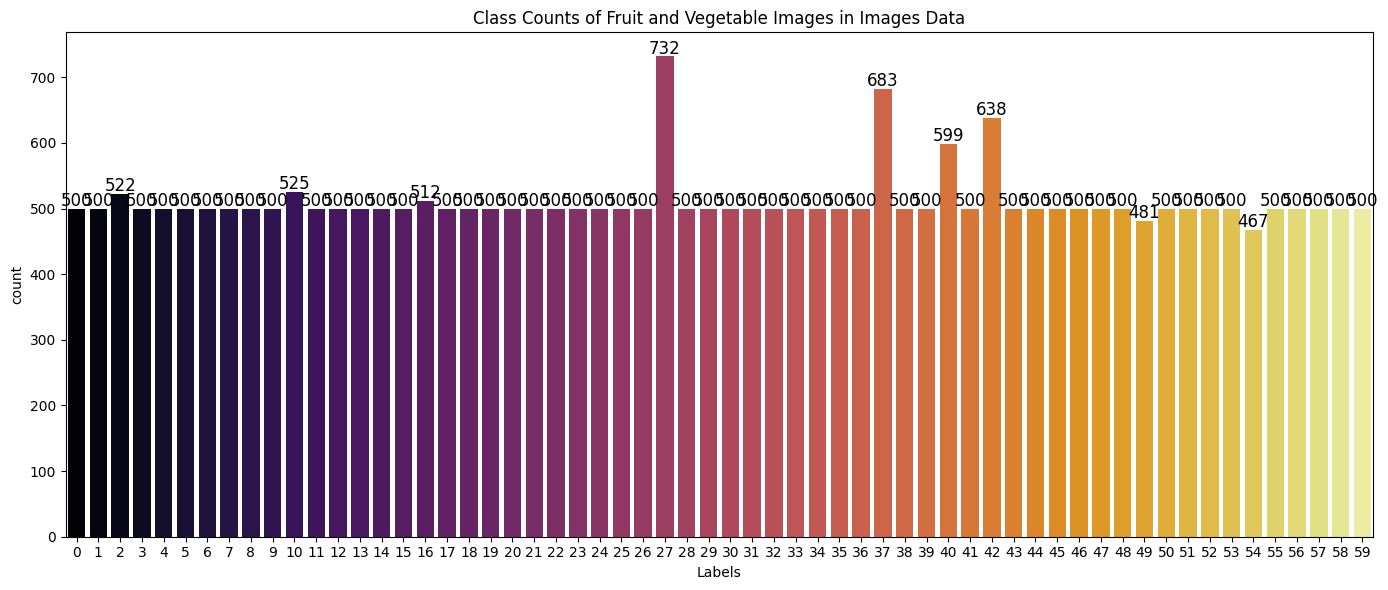

In [51]:
def count_label(y, title):
    plt.figure(figsize=(14, 6))
    ax = sns.countplot(x=y, palette='inferno')
    plt.xlabel('Labels')
    plt.title(f'Class Counts of Fruit and Vegetable Images in {title} Data')
    
    # Her çubuğun üzerine sayıları ekleme
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='baseline', 
                    fontsize=12, color='black', 
                    xytext=(0, 2),  # Yüksekliği ayarlamak için
                    textcoords='offset points')
    
    plt.tight_layout()
    plt.show()

# Örnek kullanım
count_label(train_generator.classes, 'Images')

<a id="4.1"></a>
### Visualize Training Images 

In [52]:
import random
from PIL import Image

def plot_one_image_per_class_from_folder(folder_path, class_names, img_size=(224, 224)):
    """
    每個類別顯示一張圖片，標題為類別名稱。
    適用於 flow_from_directory 的資料結構。
    """
    fig, axes = plt.subplots(6, 10, figsize=(10, 10))
    axes = axes.flat
    for i, class_name in enumerate(class_names):
        class_dir = os.path.join(folder_path, class_name)
        img_files = [f for f in os.listdir(class_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        if not img_files:
            continue
        img_file = random.choice(img_files)
        img_path = os.path.join(class_dir, img_file)
        img = Image.open(img_path).resize(img_size)
        axes[i].imshow(img)
        axes[i].set_title(class_name, fontsize=10)
        axes[i].axis('off')
    # 關閉多餘的子圖
    for j in range(i+1, 60):
        axes[j].axis('off')
    plt.tight_layout(pad=0.3)
    plt.show()

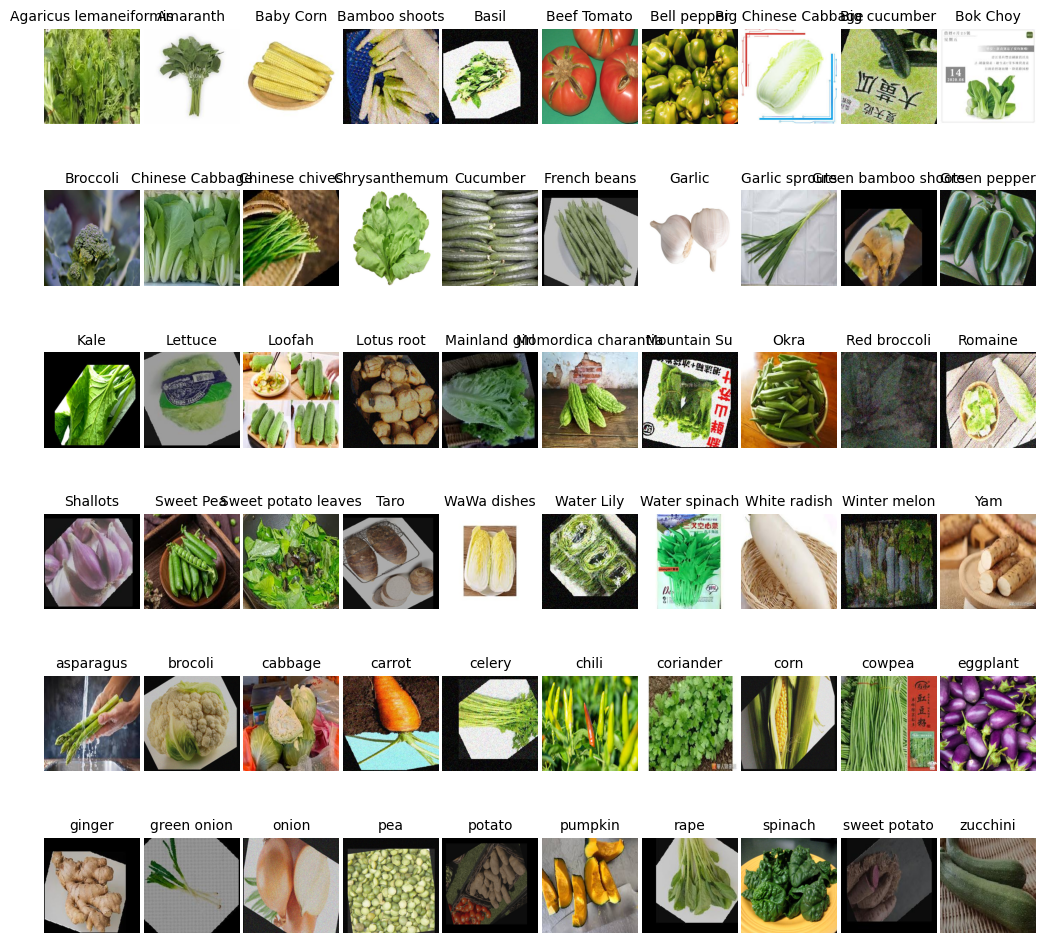

In [53]:
plot_one_image_per_class_from_folder(train_path, classes, img_size=(224, 224))

<a id="5"></a>
## 5-Data Augmentation

#### mixup_generator

In [55]:
import numpy as np

def mixup_generator(generator, alpha=0.2):
    """
    建立一個應用 Mixup 資料增強的 generator。

    參數:
    - generator: Keras 的 ImageDataGenerator 實例 (例如 train_generator_aug)。
    - alpha: Beta 分布的參數，控制混合的強度。alpha 越大，混合程度越高。
             常見的設定值為 0.2 或 0.4。
    """
    while True:
        # 從原始 generator 取得一個 batch 的資料
        x1, y1 = next(generator)
        
        # 取得 batch size
        batch_size = len(x1)
        
        # 產生 lambda 值
        # 我們從 Beta(alpha, alpha) 分布中為 batch 中的每個樣本抽取一個 lambda
        l = np.random.beta(alpha, alpha, batch_size)
        
        # 建立一個隨機索引，用於配對混合的圖片
        idx = np.random.permutation(batch_size)
        
        # 取得要混合的第二組圖片與標籤
        x2, y2 = x1[idx], y1[idx]
        
        # 根據 lambda 調整圖片和標籤的維度以進行混合
        # 調整圖片的 lambda 維度: (batch_size,) -> (batch_size, 1, 1, 1)
        x_l = l.reshape(batch_size, 1, 1, 1)
        # 調整標籤的 lambda 維度: (batch_size,) -> (batch_size, 1)
        y_l = l.reshape(batch_size, 1)
        
        # 執行 Mixup
        mixed_x = x1 * x_l + x2 * (1 - x_l)
        mixed_y = y1 * y_l + y2 * (1 - y_l)
        
        # 回傳混合後的 batch
        yield mixed_x, mixed_y

In [74]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen_aug = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.9, 1.1],
    fill_mode='nearest'
)

# 建立基礎的訓練資料 generator
train_generator_aug = train_datagen_aug.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False # 確保 shuffle 是 True，這對 Mixup 很重要
)


# --- Mixup 設定 ---
# 這是一個可以調整的超參數
mixup_alpha = 0.2

# 使用我們定義的函式，建立 Mixup generator
# 注意：這裡使用了上面的 mixup_generator 函式定義
train_mixup_generator = mixup_generator(train_generator_aug, alpha=mixup_alpha)



Found 30659 images belonging to 60 classes.


<a id="6"></a>
## 6-Build and Train the Model 

In [73]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import mlflow
import mlflow.tensorflow
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import os

# ===================================================================
# 1. 定義所有用於繪圖和記錄的輔助函式
# ===================================================================

def plot_and_log_history(history, filename="history_plots.png"):
    """
    繪製準確率和損失函數的歷史曲線，並將其儲存為圖片，最後記錄到 MLflow。
    """
    plt.figure(figsize=(12, 5))
    
    # 準確率圖
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.ylim(0, 1)
    plt.yticks(np.arange(0, 1.1, 0.1))
    plt.legend()
    plt.title('Accuracy over epochs')
    plt.show()
    
    # 損失函數圖
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.legend()
    plt.title('Loss over epochs')
    plt.show()
    
    # 儲存圖片並關閉繪圖，防止直接顯示
    plt.tight_layout()
    plt.savefig(filename)
    plt.close()
    
    # 將圖片記錄到 MLflow
    mlflow.log_artifact(filename)
    print(f"'{filename}' has been logged to MLflow.")


def log_confusion_matrix(y_true, y_pred, class_labels, filename="confusion_matrix.png"):
    """ 繪製、儲存並記錄標準混淆矩陣 """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(15, 10))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
    plt.xlabel('預測類別')
    plt.ylabel('真實類別')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.savefig(filename)
    plt.close()
    mlflow.log_artifact(filename)
    print(f"'{filename}' has been logged to MLflow.")


def plot_and_log_sorted_confusion_bar(y_true, y_pred, class_labels, filename="sorted_correct_counts.png"):
    """ 計算、繪製並記錄一個長條圖，顯示每個類別的正確預測數量（由高到低排序）。 """
    cm = confusion_matrix(y_true, y_pred)
    correct_counts = np.diag(cm)
    
    sorted_idx = np.argsort(correct_counts)[::-1]
    sorted_counts = correct_counts[sorted_idx]
    sorted_labels = np.array(class_labels)[sorted_idx]

    plt.figure(figsize=(15, 8))
    plt.bar(range(len(sorted_counts)), sorted_counts, color='lightgreen')
    plt.xticks(range(len(sorted_labels)), sorted_labels, rotation=90)
    plt.xlabel('類別')
    plt.ylabel('正確預測數量')
    plt.title('各類別正確預測數量 (由高至低排序)')
    plt.tight_layout()
    
    plt.savefig(filename)
    plt.close()

    mlflow.log_artifact(filename)
    print(f"'{filename}' has been logged to MLflow.")


def evaluate_and_log_all_reports(model, data_generator, class_labels):
    """
    評估模型並記錄分類報告、混淆矩陣及其他分析圖到 MLflow。
    確保 generator 的 shuffle=False，並 reset 順序。
    """
    print("\nStarting model evaluation for logging...")

    # 確保資料生成器順序固定
    if data_generator.shuffle:
        print("⚠️ 警告: generator 設定為 shuffle=True，將導致結果錯誤，請改成 shuffle=False")
    
    # 重置 generator，避免上次迭代影響
    data_generator.reset()

    # 1. 取得真實標籤
    y_true = data_generator.classes

    # 2. 模型預測
    predictions = model.predict(data_generator, steps=len(data_generator), verbose=1)
    y_pred = np.argmax(predictions, axis=1)

    # 確保長度一致
    if len(y_pred) != len(y_true):
        print(f"⚠️ y_pred 長度 {len(y_pred)} 與 y_true {len(y_true)} 不一致，將截斷對齊")
        y_pred = y_pred[:len(y_true)]

    # 3. 產生並記錄分類報告
    report = classification_report(y_true, y_pred, target_names=class_labels, digits=4)
    print("Classification Report:\n", report)
    mlflow.log_text(report, "classification_report.txt")
    print("'classification_report.txt' has been logged to MLflow.")

    # 4. 混淆矩陣
    log_confusion_matrix(y_true, y_pred, class_labels)

    # 5. 排序正確預測數量
    plot_and_log_sorted_confusion_bar(y_true, y_pred, class_labels)





In [ ]:
# def plot_and_log_history(history, filename="history_plots.png"):
#     """
#     繪製準確率和損失函數的歷史曲線，並將其儲存為圖片，最後記錄到 MLflow。
#     """
#     plt.figure(figsize=(12, 5))
    
#     # 準確率圖
#     plt.subplot(1, 2, 1)
#     plt.plot(history.history['accuracy'], label='Train Accuracy')
#     plt.plot(history.history['val_accuracy'], label='Val Accuracy')
#     plt.ylim(0, 1)
#     plt.yticks(np.arange(0, 1.1, 0.1))
#     plt.legend()
#     plt.title('Accuracy over epochs')
    
#     # 損失函數圖
#     plt.subplot(1, 2, 2)
#     plt.plot(history.history['loss'], label='Train Loss')
#     plt.plot(history.history['val_loss'], label='Val Loss')
#     plt.legend()
#     plt.title('Loss over epochs')
    
#     # 儲存圖片並關閉繪圖，防止直接顯示
#     plt.savefig(filename)
#     plt.close()
    
#     # 將圖片記錄到 MLflow
#     mlflow.log_artifact(filename)
#     print(f"'{filename}' has been logged to MLflow.")

In [ ]:
# import os
# import tensorflow as tf

# def check_images(data_dir):
#     corrupted_files = []
#     for root, dirs, files in os.walk(data_dir):
#         for fname in files:
#             fpath = os.path.join(root, fname)
#             try:
#                 image = tf.io.read_file(fpath)
#                 tf.io.decode_image(image)
#             except:
#                 corrupted_files.append(fpath)
#     return corrupted_files

# bad_files = check_images("dataset_full_en")
# print("壞圖數量:", len(bad_files))
# for f in bad_files:
#     print(f)


In [ ]:
# for i, (img_batch, label_batch) in enumerate(test_dataset):
#     try:
#         test_images.extend(img_batch.numpy())
#         test_labels.extend(label_batch.numpy())
#     except Exception as e:
#         print(f"Error in batch {i}: {e}")
#         break

Error in batch 0: 'numpy.ndarray' object has no attribute 'extend'


In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.metrics import confusion_matrix
# from matplotlib.colors import LogNorm

# def pred_and_cm(model, data_generator, class_names):
#     """
#     model: 已訓練好的模型
#     data_generator: validation_generator 或 test_generator
#     class_names: 類別名稱 list
#     """
#     # 取得所有資料的預測與真實標籤
#     y_true = data_generator.classes
#     y_pred = []
#     # 預測所有 batch
#     for i in range(len(data_generator)):
#         x_batch, _ = data_generator[i]
#         preds = model.predict(x_batch, verbose=0)
#         y_pred.extend(np.argmax(preds, axis=1))
#     y_pred = np.array(y_pred[:len(y_true)])  # 防止多餘預測

#     cm = confusion_matrix(y_true, y_pred)
#     mask = (cm == 0)
#     cm_safe = np.where(cm == 0, 1e-6, cm)
#     plt.figure(figsize=(12,8))
#     ax = sns.heatmap(
#         cm_safe,
#         mask=mask,
#         annot=True,
#         cmap='viridis',
#         norm=LogNorm(vmin=1e-6, vmax=cm_safe.max()),
#         xticklabels=class_names,
#         yticklabels=class_names,
#         annot_kws={'size':12}
#     )
#     for i in range(cm.shape[0]):
#         for j in range(cm.shape[1]):
#             if cm[i, j] == 0:
#                 ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=True, color='azure', edgecolor='gray'))
#     plt.title('Confusion Matrix')
#     plt.xlabel('Predicted Class')
#     plt.ylabel('True Class')
#     plt.show()

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.metrics import classification_report, confusion_matrix

# def evaluate_and_log_performance(model, data_generator, class_labels, cm_filename="confusion_matrix.png", report_filename="classification_report.txt"):
#     """
#     評估模型效能，並將分類報告與混淆矩陣記錄到 MLflow。
#     """
#     # 取得真實標籤與預測標籤
#     y_true = data_generator.classes
#     # 使用 model.predict 來取得預測結果
#     predictions = model.predict(data_generator, steps=len(data_generator), verbose=1)
#     y_pred = np.argmax(predictions, axis=1)
    
#     # 確保標籤數量一致
#     y_pred = y_pred[:len(y_true)]

#     # 1. 分類報告
#     report = classification_report(y_true, y_pred, target_names=class_labels, digits=4)
#     print("Classification Report:\n", report)
#     # 將文字報告記錄到 MLflow
#     mlflow.log_text(report, report_filename)
#     print(f"'{report_filename}' has been logged to MLflow.")

#     # 2. 混淆矩陣
#     cm = confusion_matrix(y_true, y_pred)
#     plt.figure(figsize=(15, 10))
#     sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
#     plt.xlabel('預測類別')
#     plt.ylabel('真實類別')
#     plt.title('Confusion Matrix')
    
#     # 儲存圖片並關閉繪圖
#     plt.savefig(cm_filename)
#     plt.close()

#     # 將混淆矩陣圖片記錄到 MLflow
#     mlflow.log_artifact(cm_filename)
#     print(f"'{cm_filename}' has been logged to MLflow.")

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.metrics import confusion_matrix

# def plot_sorted_confusion_bar(model, data_generator, class_labels):
#     """
#     顯示每個類別預測正確數量的長條圖（依正確數量排序）。
#     """
#     # 取得所有真實標籤
#     y_true = data_generator.classes
#     # 預測所有 batch
#     y_pred = []
#     for i in range(len(data_generator)):
#         x_batch, _ = data_generator[i]
#         preds = model.predict(x_batch, verbose=0)
#         y_pred.extend(np.argmax(preds, axis=1))
#     y_pred = np.array(y_pred[:len(y_true)])

#     # 混淆矩陣
#     cm = confusion_matrix(y_true, y_pred)
#     correct_counts = np.diag(cm)
#     # 排序
#     sorted_idx = np.argsort(correct_counts)[::-1]
#     sorted_counts = correct_counts[sorted_idx]
#     sorted_labels = np.array(class_labels)[sorted_idx]

#     # 畫長條圖
#     plt.figure(figsize=(14, 6))
#     plt.bar(range(len(sorted_counts)), sorted_counts, color='skyblue')
#     plt.xticks(range(len(sorted_labels)), sorted_labels, rotation=90)
#     plt.xlabel('class')
#     plt.ylabel('correct count')
#     plt.title('correct count of class (sorted by correct count)')
#     plt.tight_layout()
#     plt.show()

<a id="6.3"></a>
### MobileNetV2 Model with no Augmentation

In [ ]:
mobile_net_model = keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),  # 與 generator target_size 一致
    include_top=False, weights='imagenet'
)
mobile_net_model.trainable = True
for layer in mobile_net_model.layers[:-60]:
    layer.trainable = False

model_mnV2 = keras.Sequential([
    mobile_net_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

model_mnV2.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',  # 若 class_mode='categorical'
    metrics=['accuracy']
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=2,
    min_lr=1e-8
)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "model_checkpoint.keras",
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=False,
    verbose=0,
)

callbacks = [early_stop, reduce_lr, checkpoint]

history = model_mnV2.fit(
    train_generator_aug,
    epochs=50,
    validation_data=validation_generator,
    class_weight=class_weight,
    callbacks=callbacks,
    verbose=1
)
result_mobile_net_model = pd.DataFrame(history.history)

Epoch 1/30
959/959 ━━━━━━━━━━━━━━━━━━━━ 0s 668ms/step - accuracy: 0.2353 - loss: 3.1269
Epoch 1: val_loss improved from inf to 1.15149, saving model to model_checkpoint.keras
959/959 ━━━━━━━━━━━━━━━━━━━━ 731s 757ms/step - accuracy: 0.2355 - loss: 3.1261 - val_accuracy: 0.6706 - val_loss: 1.1515 - learning_rate: 1.0000e-04
Epoch 2/30
959/959 ━━━━━━━━━━━━━━━━━━━━ 0s 503ms/step - accuracy: 0.6547 - loss: 1.2168
Epoch 2: val_loss did not improve from 1.15149
959/959 ━━━━━━━━━━━━━━━━━━━━ 532s 554ms/step - accuracy: 0.6548 - loss: 1.2167 - val_accuracy: 0.6750 - val_loss: 1.1785 - learning_rate: 1.0000e-04
Epoch 3/30
959/959 ━━━━━━━━━━━━━━━━━━━━ 0s 504ms/step - accuracy: 0.7580 - loss: 0.8325
Epoch 3: val_loss improved from 1.15149 to 0.87352, saving model to model_checkpoint.keras
959/959 ━━━━━━━━━━━━━━━━━━━━ 530s 552ms/step - accuracy: 0.7580 - loss: 0.8324 - val_accuracy: 0.7660 - val_loss: 0.8735 - learning_rate: 1.0000e-04
Epoch 4/30
959/959 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step - accuracy

In [69]:
# --- MLflow 設定 ---
mlflow.tensorflow.autolog() # 自動記錄指標、參數和模型
mlflow.set_experiment("MobileNetV2_優化實驗")

# --- MLflow 設定與訓練 ---
# 將 mixup_alpha 也加入到超參數中進行監控
params = {
    'learning_rate': 0.0001,
    'dropout_rate_1': 0.3,
    'dropout_rate_2': 0.3,
    'dense_units_1': 256,
    'dense_units_2': 256,
    'trainable_layers': 60,
    'epochs': 50,
    'mixup_alpha': mixup_alpha # 新增 Mixup alpha 參數
}


# 開始一個 MLflow run
with mlflow.start_run() as run:
    print(f"Starting MLflow Run: {run.info.run_name}")
    mlflow.log_params(params)

    # --- 模型定義 ---
    mobile_net_model = keras.applications.MobileNetV2(
        input_shape=(224, 224, 3),
        include_top=False,
        weights='imagenet'
    )
    mobile_net_model.trainable = True
    for layer in mobile_net_model.layers[:-params['trainable_layers']]:
        layer.trainable = False

    model_mnV2 = keras.Sequential([
        mobile_net_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(params['dense_units_1'], activation='relu'),
        layers.Dropout(params['dropout_rate_1']),
        layers.Dense(params['dense_units_2'], activation='relu'),
        layers.Dropout(params['dropout_rate_2']),
        layers.Dense(num_classes, activation='softmax')
    ])

    # --- 編譯模型 ---
    model_mnV2.compile(
        optimizer=Adam(learning_rate=params['learning_rate']),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # --- 回呼函式 ---
    early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=1e-8)
    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        "model_checkpoint.keras", monitor="val_loss", save_best_only=True
    )
    callbacks = [early_stop, reduce_lr, checkpoint]

    # --- 訓練模型 ---
    history = model_mnV2.fit(
        train_generator_aug,
        epochs=params['epochs'],
        validation_data=validation_generator,
        # class_weight=class_weight,
        callbacks=callbacks,
        verbose=1
    )

     # --- 訓練後評估與記錄 ---
    # 取得類別標籤，確保順序正確
    class_labels = list(validation_generator.class_indices.keys())
    
    # 1. 記錄訓練歷史圖表
    plot_and_log_history(history)
    
    # 2. 執行所有評估並記錄報告與圖表
    evaluate_and_log_all_reports(model_mnV2, validation_generator, class_labels)

    print(f"\nMLflow Run {run.info.run_name} finished and all artifacts logged.")
    print("您現在可以在終端機執行 'mlflow ui' 來查看結果。")

Starting MLflow Run: rare-shrimp-75


2025/08/04 22:38:55 WARNING mlflow.tensorflow: Unrecognized dataset type <class 'keras.src.legacy.preprocessing.image.DirectoryIterator'>. Dataset logging skipped.
2025/08/04 22:38:55 WARNING mlflow.tensorflow: Unrecognized dataset type <class 'keras.src.legacy.preprocessing.image.DirectoryIterator'>. Dataset logging skipped.


Epoch 1/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 0s 846ms/step - accuracy: 0.1941 - loss: 3.3270

959/959 ━━━━━━━━━━━━━━━━━━━━ 875s 905ms/step - accuracy: 0.1943 - loss: 3.3262 - val_accuracy: 0.6706 - val_loss: 1.1458 - learning_rate: 1.0000e-04
Epoch 2/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 0s 970ms/step - accuracy: 0.6186 - loss: 1.3623

959/959 ━━━━━━━━━━━━━━━━━━━━ 980s 1s/step - accuracy: 0.6187 - loss: 1.3622 - val_accuracy: 0.7436 - val_loss: 0.9529 - learning_rate: 1.0000e-04
Epoch 3/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 0s 967ms/step - accuracy: 0.7228 - loss: 0.9763

959/959 ━━━━━━━━━━━━━━━━━━━━ 977s 1s/step - accuracy: 0.7228 - loss: 0.9763 - val_accuracy: 0.7758 - val_loss: 0.8189 - learning_rate: 1.0000e-04
Epoch 4/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 0s 963ms/step - accuracy: 0.7788 - loss: 0.7768

959/959 ━━━━━━━━━━━━━━━━━━━━ 974s 1s/step - accuracy: 0.7788 - loss: 0.7768 - val_accuracy: 0.8073 - val_loss: 0.7280 - learning_rate: 1.0000e-04
Epoch 5/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 976s 1s/step - accuracy: 0.8130 - loss: 0.6310 - val_accuracy: 0.7979 - val_loss: 0.8152 - learning_rate: 1.0000e-04
Epoch 6/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 756s 788ms/step - accuracy: 0.8413 - loss: 0.5495 - val_accuracy: 0.8059 - val_loss: 0.7902 - learning_rate: 1.0000e-04
Epoch 7/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 0s 577ms/step - accuracy: 0.8698 - loss: 0.4438

959/959 ━━━━━━━━━━━━━━━━━━━━ 591s 617ms/step - accuracy: 0.8698 - loss: 0.4437 - val_accuracy: 0.8474 - val_loss: 0.6242 - learning_rate: 1.0000e-05
Epoch 8/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 0s 574ms/step - accuracy: 0.8805 - loss: 0.3974

959/959 ━━━━━━━━━━━━━━━━━━━━ 589s 614ms/step - accuracy: 0.8805 - loss: 0.3974 - val_accuracy: 0.8530 - val_loss: 0.5973 - learning_rate: 1.0000e-05
Epoch 9/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 0s 573ms/step - accuracy: 0.8930 - loss: 0.3601

959/959 ━━━━━━━━━━━━━━━━━━━━ 588s 614ms/step - accuracy: 0.8930 - loss: 0.3601 - val_accuracy: 0.8525 - val_loss: 0.5972 - learning_rate: 1.0000e-05
Epoch 10/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 0s 579ms/step - accuracy: 0.8984 - loss: 0.3373

959/959 ━━━━━━━━━━━━━━━━━━━━ 599s 624ms/step - accuracy: 0.8984 - loss: 0.3373 - val_accuracy: 0.8537 - val_loss: 0.5894 - learning_rate: 1.0000e-05
Epoch 11/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 601s 627ms/step - accuracy: 0.9024 - loss: 0.3290 - val_accuracy: 0.8567 - val_loss: 0.5936 - learning_rate: 1.0000e-05
Epoch 12/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 572s 596ms/step - accuracy: 0.9051 - loss: 0.3144 - val_accuracy: 0.8528 - val_loss: 0.5988 - learning_rate: 1.0000e-05
Epoch 13/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 566s 590ms/step - accuracy: 0.9095 - loss: 0.2964 - val_accuracy: 0.8535 - val_loss: 0.5984 - learning_rate: 1.0000e-06
Epoch 14/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 568s 592ms/step - accuracy: 0.9113 - loss: 0.2962 - val_accuracy: 0.8553 - val_loss: 0.5986 - learning_rate: 1.0000e-06
Epoch 15/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 568s 592ms/step - accuracy: 0.9134 - loss: 0.2910 - val_accuracy: 0.8553 - val_loss: 0.5990 - learning_rate: 1.0000e-07
Epoch 16/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 600s 

2025/08/05 02:07:28 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: '>=' not supported between instances of 'slice' and 'int'
2025/08/05 02:07:28 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/05 02:07:28 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2025/08/05 02:07:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


'history_plots.png' has been logged to MLflow.

Starting model evaluation for logging...
134/134 ━━━━━━━━━━━━━━━━━━━━ 38s 275ms/step
Classification Report:
                         precision    recall  f1-score   support

Agaricus lemaneiformis     0.0137    0.0156    0.0146        64
              Amaranth     0.0351    0.0325    0.0338       123
             Baby Corn     0.0360    0.0336    0.0347       149
         Bamboo shoots     0.0000    0.0000    0.0000        51
                 Basil     0.0000    0.0000    0.0000        47
           Beef Tomato     0.0446    0.0439    0.0442       114
           Bell pepper     0.0000    0.0000    0.0000        35
   Big Chinese Cabbage     0.0102    0.0099    0.0101       101
          Big cucumber     0.0200    0.0200    0.0200        50
              Bok Choy     0.0636    0.0769    0.0697        91
              Broccoli     0.0067    0.0067    0.0067       150
       Chinese Cabbage     0.0000    0.0000    0.0000        38
        Ch

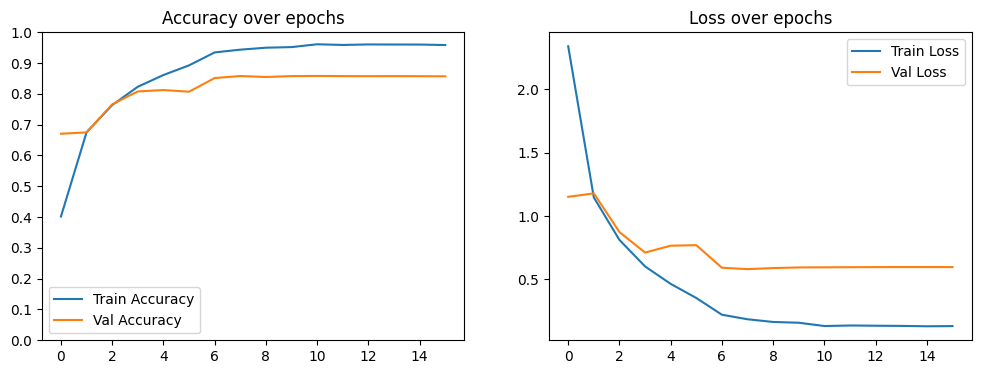

In [ ]:
# plot_history(history)

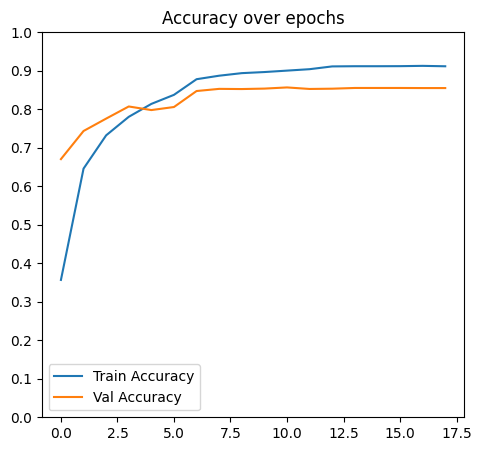

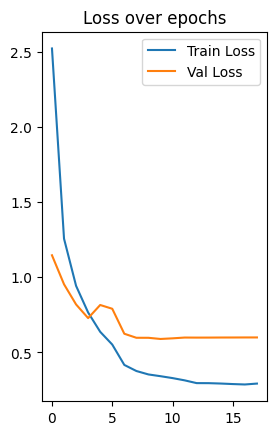

'history_plots.png' has been logged to MLflow.


In [75]:
plot_and_log_history(history)

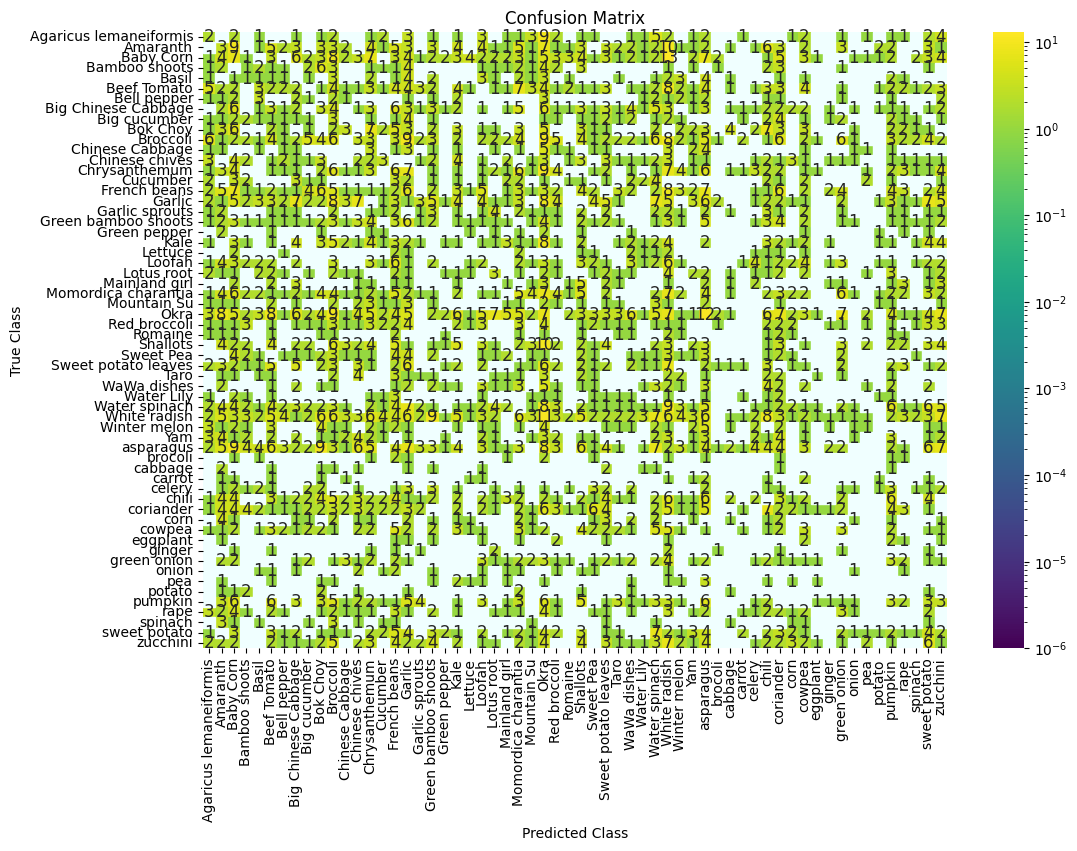

In [ ]:
# pred_and_cm(model_mnV2, validation_generator, classes)

                        precision    recall  f1-score   support

Agaricus lemaneiformis     0.0299    0.0312    0.0305        64
              Amaranth     0.0259    0.0244    0.0251       123
             Baby Corn     0.0452    0.0470    0.0461       149
         Bamboo shoots     0.0196    0.0196    0.0196        51
                 Basil     0.0213    0.0213    0.0213        47
           Beef Tomato     0.0182    0.0175    0.0179       114
           Bell pepper     0.0000    0.0000    0.0000        35
   Big Chinese Cabbage     0.0235    0.0198    0.0215       101
          Big cucumber     0.0204    0.0200    0.0202        50
              Bok Choy     0.0000    0.0000    0.0000        91
              Broccoli     0.0395    0.0400    0.0397       150
       Chinese Cabbage     0.0000    0.0000    0.0000        38
        Chinese chives     0.0260    0.0282    0.0270        71
         Chrysanthemum     0.0270    0.0275    0.0273       109
              Cucumber     0.0000    0.

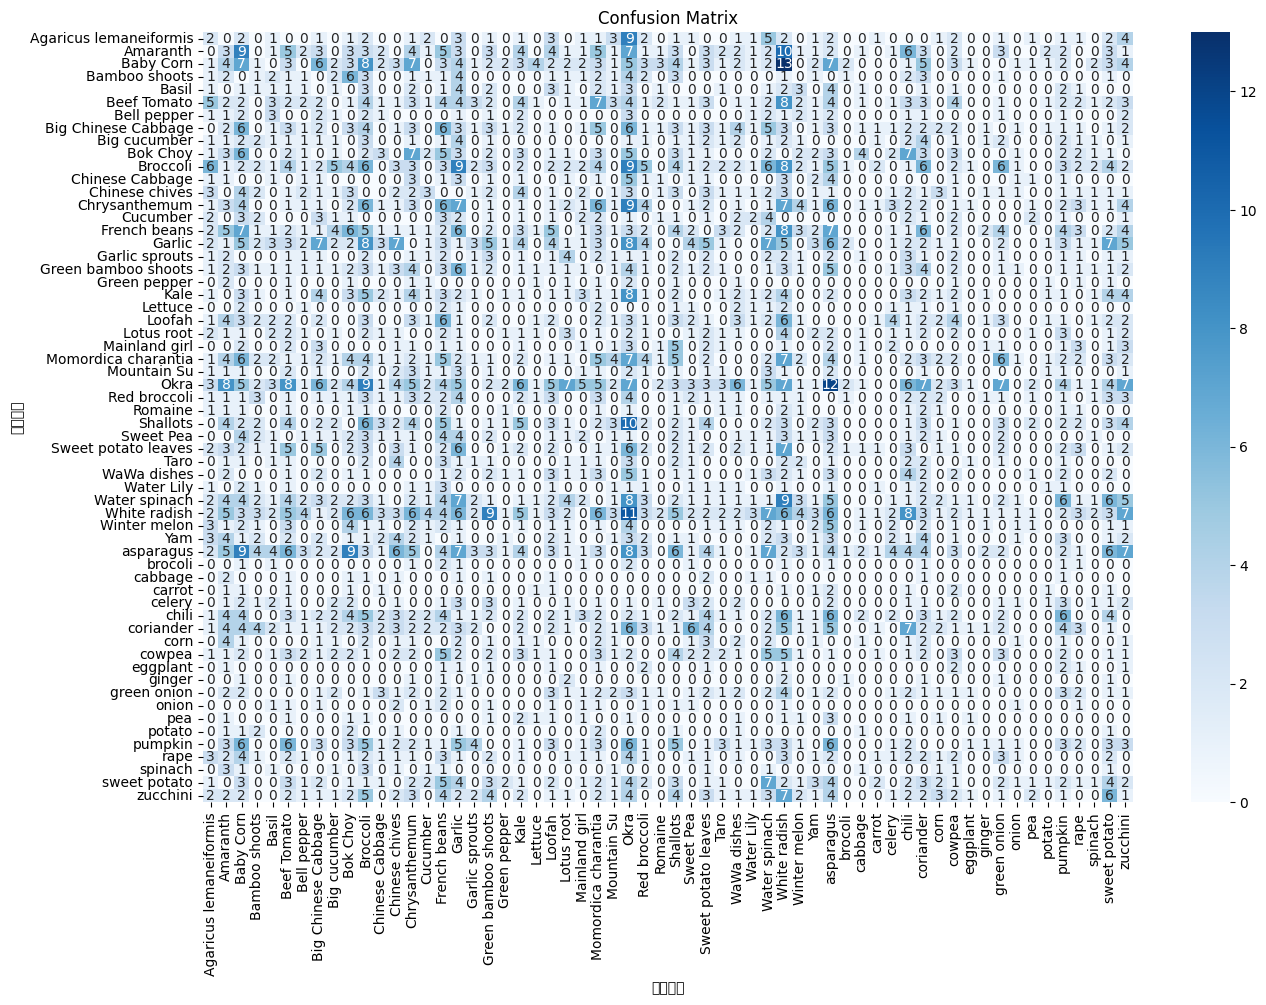

In [ ]:
# evaluate_model_performance(model_mnV2, validation_generator, classes)

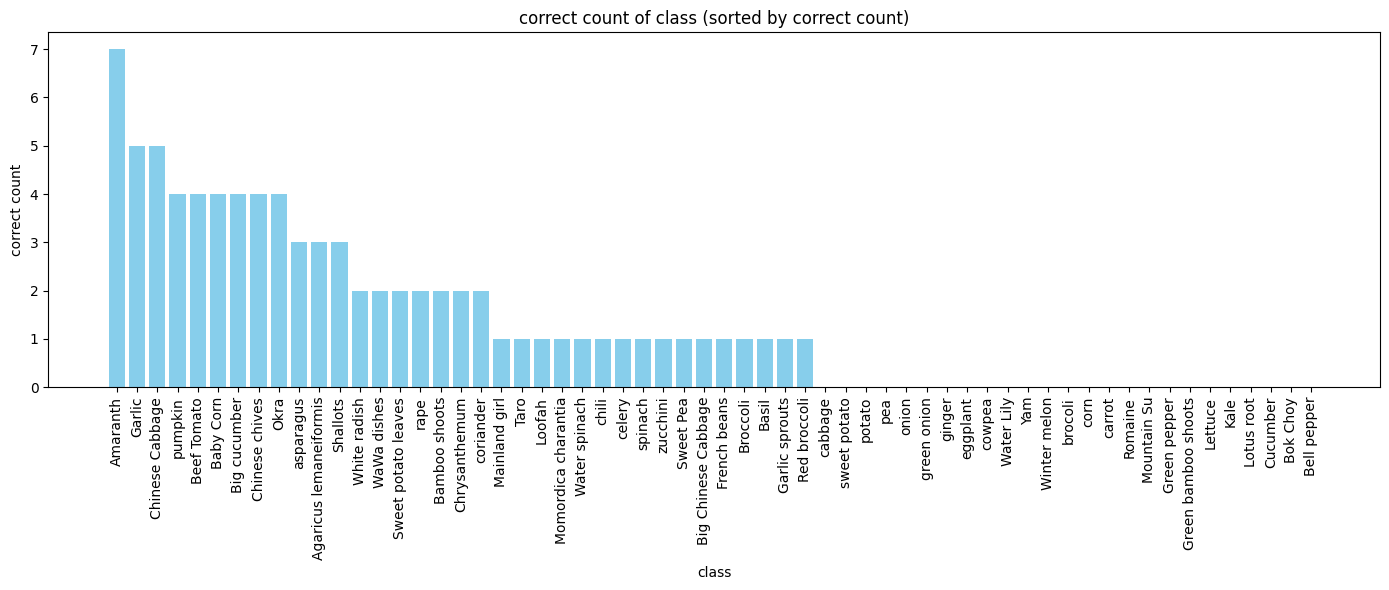

In [ ]:
# plot_sorted_confusion_bar(model_mnV2, validation_generator, classes)

In [77]:
model_mnV2.save('model_mnV2(best).keras') 
model_mnV2.save('model_mnV2(best).h5') 

In [76]:
result_mobile_net_model.tail(5)

,accuracy,loss,val_accuracy,val_loss,learning_rate
11,0.958838,0.136610,0.857676,0.596303,1.000000e-06
12,0.960501,0.134795,0.857443,0.597086,1.000000e-07
13,0.960240,0.133487,0.857676,0.597524,1.000000e-07
14,0.960142,0.130464,0.857443,0.597441,1.000000e-08
15,0.958544,0.131900,0.856976,0.597171,1.000000e-08


## model_mnV2_best 再訓練

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import load_img, img_to_array
import tensorflow as tf

# 載入模型
model_mnV2_best = load_model('model_mnV2(best).keras')

mobile_net_model = keras.applications.MobileNetV2(input_shape=(128,128,3), 
                                                 include_top=False, weights='imagenet')
mobile_net_model.trainable = True 
for layer in mobile_net_model.layers[:-20]:
    layer.trainable = False

model_mnV2_best = keras.Sequential([
    mobile_net_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

model_mnV2_best.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics =['accuracy']
)


history = model_mnV2_best.fit(
    train_dataset,
    epochs=20,
    validation_data=test_dataset,
    callbacks=callbacks,
    verbose=0
)
plot_history(history)
result_model_mnV2_best = pd.DataFrame(history.history)

KeyboardInterrupt: 

In [83]:
# 如果有還沒結束的 run，先結束
if mlflow.active_run():
    mlflow.end_run()

#  MLflow 設定
mlflow.tensorflow.autolog()
mlflow.set_experiment("MobileNetV2_續訓實驗")

# 載入最佳模型
best_model_path = "model_mnV2(best).keras"
model_mnV2_best = load_model(best_model_path)
print(f"✅ 已載入最佳模型: {best_model_path}")

# 可選擇是否凍結部分層
# 取得 MobileNetV2 卷積部分
base_model = None
for layer in model_mnV2_best.layers:
    if 'mobilenetv2' in layer.name.lower():  # 用名稱判斷
        base_model = layer
        break

if base_model:
    print(f"✅ 找到 MobileNetV2 backbone，總層數: {len(base_model.layers)}")
    for layer in base_model.layers[:-20]:
        layer.trainable = False
else:
    print("⚠️ 未找到 MobileNetV2 backbone，將直接使用整個模型進行續訓")

# 凍結除了最後60層的其他層
for layer in base_model.layers[:-60]:
    layer.trainable = False
for layer in base_model.layers[-60:]:
    layer.trainable = True

# BatchNorm層保持可訓練
for layer in base_model.layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True



# 重新編譯模型 (降低 learning rate)
model_mnV2_best.compile(
    optimizer=Adam(learning_rate=1e-5),  # 微調時通常降低學習率
    loss='categorical_crossentropy',     # 保持與之前一致
    metrics=['accuracy']
)


# MLflow 記錄續訓超參數
params = {
    'learning_rate': 1e-5,
    "trainable_layers": 60,
    'epochs': 20,
    'mode': 'fine-tune-best-model'
}

with mlflow.start_run() as run:
    mlflow.log_params(params)
    
    
    # Callbacks 設定
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-9)
    checkpoint = ModelCheckpoint("model_mnV2(finetuned).keras", monitor='val_loss', save_best_only=True)

    callbacks = [early_stop, reduce_lr, checkpoint]
    

    # 繼續訓練
    history = model_mnV2_best.fit(
    train_generator_aug,
    epochs=params['epochs'],
    validation_data=validation_generator,
    callbacks=callbacks,
    verbose=1
    )

    # 將歷史記錄轉成 DataFrame
    result_df = pd.DataFrame(history.history)
    print(result_df.tail())



     # 取得類別標籤，確保順序正確
    class_labels = list(validation_generator.class_indices.keys())
    # 1. 記錄訓練歷史圖表
    plot_and_log_history(history)
    
    # 2. 執行所有評估並記錄報告與圖表
    evaluate_and_log_all_reports(model_mnV2, validation_generator, class_labels)

    print(f"\n✅ 續訓完成，最佳模型儲存在 model_mnV2(finetuned).keras")
    print(f"查看 MLflow 結果：mlflow ui")

✅ 已載入最佳模型: model_mnV2(best).keras
✅ 找到 MobileNetV2 backbone，總層數: 154


2025/08/05 22:05:13 WARNING mlflow.tensorflow: Unrecognized dataset type <class 'keras.src.legacy.preprocessing.image.DirectoryIterator'>. Dataset logging skipped.
2025/08/05 22:05:13 WARNING mlflow.tensorflow: Unrecognized dataset type <class 'keras.src.legacy.preprocessing.image.DirectoryIterator'>. Dataset logging skipped.


Epoch 1/20
959/959 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.0454 - loss: 4.8036

959/959 ━━━━━━━━━━━━━━━━━━━━ 1563s 2s/step - accuracy: 0.0454 - loss: 4.8031 - val_accuracy: 0.8336 - val_loss: 0.7882 - learning_rate: 1.0000e-05
Epoch 2/20
959/959 ━━━━━━━━━━━━━━━━━━━━ 1471s 2s/step - accuracy: 0.0616 - loss: 4.0278 - val_accuracy: 0.8171 - val_loss: 0.9998 - learning_rate: 1.0000e-05
Epoch 3/20
 50/959 ━━━━━━━━━━━━━━━━━━━━ 23:09 2s/step - accuracy: 0.0668 - loss: 3.9600

KeyboardInterrupt: 

In [ ]:
result_mobile_net_model.tail(5)

NameError: name 'result_mobile_net_model' is not defined

### 單張測試

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import load_img, img_to_array
import tensorflow as tf

# 載入模型
model_mnV2_best = load_model('model_mnV2(best).keras')

# 載入圖片
img = load_img("甜椒.jpg", target_size=(128, 128))
img_array = img_to_array(img) / 255.0
img_array = tf.expand_dims(img_array, axis=0)  # shape: (1, 224, 224, 3)

print(classes)

# 預測
pred = model_mnV2_best.predict(img_array)
pred = tf.argmax(pred, axis=1).numpy()[0]
print(pred)
print(classes[pred])

['Agaricus lemaneiformis', 'Amaranth', 'Baby Corn', 'Bamboo shoots', 'Basil', 'Beef Tomato', 'Bell pepper', 'Big Chinese Cabbage', 'Big cucumber', 'Bok Choy', 'Broccoli', 'Chinese Cabbage', 'Chinese chives', 'Chrysanthemum', 'Cucumber', 'French beans', 'Garlic', 'Garlic sprouts', 'Green bamboo shoots', 'Green pepper', 'Kale', 'Lettuce', 'Loofah', 'Lotus root', 'Mainland girl', 'Momordica charantia', 'Mountain Su', 'Okra', 'Red broccoli', 'Romaine', 'Shallots', 'Sweet Pea', 'Sweet potato leaves', 'Taro', 'WaWa dishes', 'Water Lily', 'Water spinach', 'White radish', 'Winter melon', 'Yam', 'asparagus', 'brocoli', 'cabbage', 'carrot', 'celery', 'chili', 'coriander', 'corn', 'cowpea', 'eggplant', 'ginger', 'green onion', 'onion', 'pea', 'potato', 'pumpkin', 'rape', 'spinach', 'sweet potato', 'zucchini']
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step
6
Bell pepper


#### model_mnV2 Visualization 

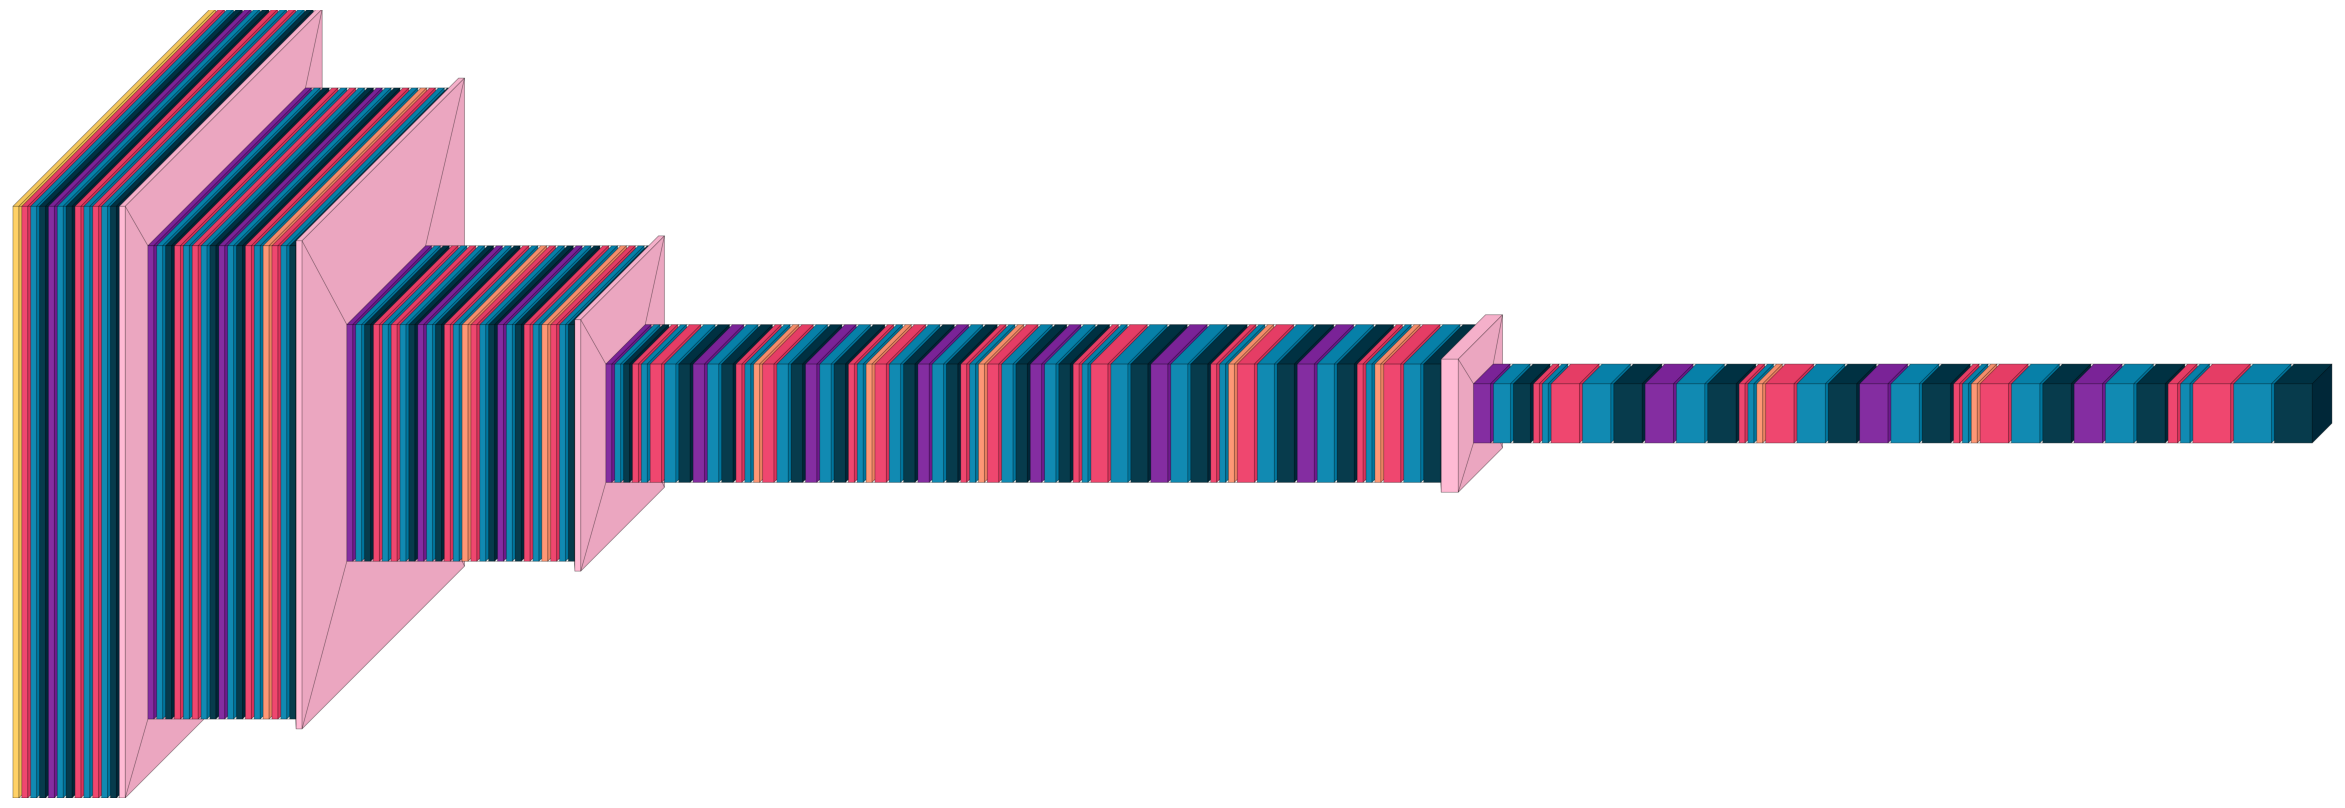

In [ ]:
visualkeras.layered_view(mobile_net_model,to_file=vis_path, scale_xy=50)

img = Image.open(vis_path)
plt.figure(figsize=(30,30))
plt.imshow(img)
plt.axis('off')
plt.show()

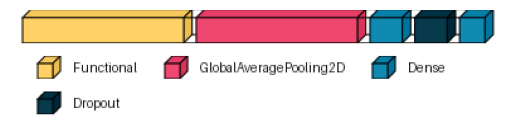

In [ ]:
vis_path = '/kaggle/working/model_mnV2.png'
visualkeras.layered_view(model_mnV2, to_file=vis_path, legend=True)

img = Image.open(vis_path)
plt.figure()
plt.imshow(img)
plt.axis('off')
plt.show()

In [ ]:
model_mnV2_aug.save('model_mnV2_aug.h5')

In [ ]:
num_classes = len(os.listdir(train_path))
num_classes

batch_size = 32
img_size = (128, 128)

# Eğitim setini yükleme
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    image_size=img_size,
    batch_size=batch_size,
)
classes = train_ds.class_names
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))

train_ds = train_ds.shuffle(buffer_size=1000)

train_size = int(0.8 * len(train_ds)) 
test_size = len(train_ds) - train_size

train_dataset = train_ds.take(train_size)
test_dataset = train_ds.skip(train_size)

print(classes)

In [ ]:
X_train, y_train = load_image(test_path)
X_train = X_train.astype('float32')/255.0

pred = model_mnV2_aug_load.predict(img_array)

<a id="7"></a>
## 7-Result

I experimented with four different models and achieved successful results with all of them. My custom models performed as well as MobileNetV2, although they required significantly more time to reach the same level of accuracy. While the models initially struggled with learning under data augmentation, I was ultimately able to overcome these challenges.

<span style="background: linear-gradient(to right, #FF5733, #33FF57, #3357FF, #FF33A1); 
    -webkit-background-clip: text; -webkit-text-fill-color: transparent; font-size: 40px; font-weight: bold">
    Thanks for Reading :)
</span>